# Principais Bibliotecas

Nesta se√ß√£o est√° contido os comandos de instala√ß√£o e importa√ß√£o das bibliotecas utilizadas neste notebook.

In [ ]:
pip install control

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 348kB 24.0MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344920 sha256=3a4c8879e364dfcfd8c06edfd2c5b53c5c94f93b583da15200a455f499895872
  Stored in directory: /root/.cache/pip/wheels/35/be/ee/081b68ca3e4b2d253fba2f7f7e51960373903fb7b6d13c5532
Successfully built control


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
import sympy
from sympy import *
init_printing()

# Principais Fun√ß√µes

### Opera√ß√µes Alg√©bricas e Transformadas de LaPlace

Fun√ß√£o da Transformada de La Place

In [ ]:
def L(f):
  return sympy.laplace_transform(f, t, s, noconds=True)

Fun√ß√£o da Transformada Inversa de La Place

In [ ]:
def invL(F):
  return sympy.inverse_laplace_transform(F, s, t)

Fun√ß√£o para deixar em fra√ß√µes parciais

In [ ]:
def fracPar(F):
  return F.apart(s)

Fun√ß√£o para Par√¢metros de desempenho da resposta ao degrau



### Resposta ao degrau


Fun√ß√£o auxiliar que calcula e mostra os par√¢metros de desempenho da resposta ao degrau

In [ ]:
def step_info(t, y, SettlingTimeThreshold, RiseTimeLimits, Amp):
  
  InfValue = y[-1]

  #RiseTime
  tr_lower_index = (np.where(y >= RiseTimeLimits[0] * InfValue)[0])[0]
  tr_upper_index = (np.where(y >= RiseTimeLimits[1] * InfValue)[0])[0]
  RiseTime = t[tr_upper_index] - t[tr_lower_index]

  # SettlingTime
  sup_margin = (1. + SettlingTimeThreshold) * InfValue
  inf_margin = (1. - SettlingTimeThreshold) * InfValue
  # find Steady State looking for the first point out of specified limits
  for i in reversed(range(t.size)):
      if((y[i] <= inf_margin) | (y[i] >= sup_margin)):
          SettlingTime = t[i + 1]
          break
  # Peak
  PeakIndex = np.abs(y).argmax()
  PeakValue = y[PeakIndex]
  PeakTime = t[PeakIndex]
  SettlingMax = (y).max()
  SettlingMin = (y[tr_upper_index:]).min()
  # I'm really not very confident about UnderShoot:
  UnderShoot = y.min()
  OverShoot = 100. * (y.max() - InfValue) / (InfValue - y[0])

  # Eest
  Eest = Amp-InfValue

  # Return as a dictionary
  S = {
      #'RiseTime': RiseTime,
      'Tempo de Estabiliza√ß√£o': SettlingTime,
      #'SettlingMin': SettlingMin,
      #'SettlingMax': SettlingMax,
      'Overshoot(%)': OverShoot,
      #'Undershoot': UnderShoot,
      'Pico': PeakValue,
      'Tempo de Pico': PeakTime,
      'Valor de Estabiliza√ß√£o': InfValue,
      'Erro Estacion√°rio': Eest
    }

  return S

Fun√ß√£o que plota a resposta resposta ao degrau em fun√ß√£o do tempo m√°ximo de simula√ß√£o e mostra os par√¢metros de desempenho

In [ ]:
def plot_step(sys, T, te=0.02, ts = (0.1,0.9), Amp=1):
  xs, ys = ctrl.step_response(Amp*sys, T=T)
 
  fig, ax = plt.subplots(figsize=(7,3))
 
  ax.plot(xs, ys, linewidth=1.5)

  S = step_info(xs, ys, te, ts, Amp)
  
  return xs, ys, S

### Resposta em Frequ√™ncia

Fun√ß√£o que plota o Diagrama de Nyquist com Margem de ganho e Margem de Fase

In [ ]:
def marginNyquist(sys):
  count, countour = ctrl.nyquist_plot(sys, plot=True, #omega=np.arange(0,100, 0.1),
                                      return_contour=True)
  resp = sys(countour)
  real = resp.real
  imag = resp.imag  
  ax = plt.gca()
  ax.add_patch(plt.Circle((0,0), radius=1.0,
                      linestyle=':', edgecolor='k', linewidth=1.5,
                      fill=False, zorder=-20))
  #Margem de Fase
  a=0
  b = real.size
  pr=0
  pi=0
  for t in range(real.size):
    raio = np.sqrt(real[t]**2 + imag[t]**2)
    if np.around(raio, 2) == 1.00:
      pr = real[t]
      pi = imag[t]
      a = t
      break
  if pr == 0 and pi == 0:
    MF_nyq = 'Nan'
  else:
    angle = np.arctan(pi/pr)*180/np.pi
    MF_nyq = 180 + angle
  
  #Margem de Ganho
  wcf = ctrl.stability_margins(sys)[3]
  s = complex(0,wcf)
  MG_nyq = -20*np.log10(sys(s))
  MG_nyq = MG_nyq.real
  print('Margem de Fase: ' + str(MF_nyq) + '\nMargem de Ganho: ' + str(MG_nyq))

### Controle por Realimenta√ß√£o de Espa√ßo de Estados

Essa fun√ß√£o Realiza o comando Acker, que insere os p√≥los desejados no sistema de Espa√ßo de Estados.

In [ ]:
def acker(A, B, poles):
    
    ct = ctrl.ctrb(A, B)

    # Compute the desired characteristic polynomial
    p = np.real(np.poly(poles))

    # Place the poles using Ackermann's method
    # TODO: compute pmat using Horner's method (O(n) instead of O(n^2))
    n = np.size(p)
    pmat = p[n-1] * np.linalg.matrix_power(A, 0)
    for i in np.arange(1, n):
        pmat = pmat + np.dot(p[n-i-1], np.linalg.matrix_power(A, i))
    K = np.linalg.solve(ct, pmat)

    K = K[-1][:]                # Extract the last row
    return K

# Opera√ß√µes Alg√©bricas e Transformada de LaPlace

In [ ]:
t, s = symbols('t, s')

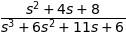

In [ ]:
F = (s**2+4*s+8)/(s**3 +6*s**2 +11*s+6)
F

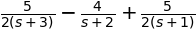

In [ ]:
F = fracPar(F)
F

In [ ]:
f = invL(F)
f

In [ ]:
f = fracPar(f)
f

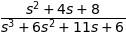

In [ ]:
F1 = L(f)
F1

In [ ]:
roots(s**3 +6*s**2 +11*s+6)

In [ ]:
factor(s**3 +6*s**2 +11*s+6)

In [ ]:
expand((s+1)*(s+2)*(s+3))

Resolu√ß√£o de EDO por LaPlace

$2\ddot{x} + 7 \dot{x} + 3x = 0 ;\quad x(0) = 3 \quad e \quad \dot{x}(0) = 0$




Primeiramente vamos criar as vari√°veis simb√≥licas e as condi√ß√µes iniciais

In [ ]:
x, X = symbols('x, X', cls=Function)
t, s = symbols('t, s')
x0 = 3
x_ponto0 = 0

Feito isso, iremos aplicar LaPlace e escrever a EDO no dom√≠nio s. Teremos que fazer isso manualmente.

$2[s^2X(s) - sx(0) - \dot{x}(0)]+ 7[sX(s) - x(0)] + 3X(s) = 0$

Feito isso iremos escrever a equa√ß√£o no dom√≠nio s a partir das vari√°veis simb√≥licas

In [ ]:
EDO = Eq((2*(s**2 * X(s)- (s*x0)- x_ponto0) + 7*(s*X(s)-x0) + 3*X(s)), 0)
EDO

Com isso basta utilizar o comando solve da biblioteca Sympy, para escrever a fun√ß√£o X(s).

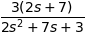

In [ ]:
TF = solve(EDO, X(s))[0]
TF

Abrindo em fra√ß√µes parciais

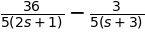

In [ ]:
TF = fracPar(TF)
TF

Utilizando a tranformada inversa de LaPlace

In [ ]:
tf_t = invL(TF)
tf_t

Portanto, podemos concluir que:
$x(t) = 3,6 \ \cdot e^{-0,5t} - 0,6 \ \cdot e^{-3t}$

# Fun√ß√£o de Transfer√™ncia Cont√≠nua e Resposta ao Degrau Unit√°rio

### Fun√ß√£o de Transfer√™ncia Cont√≠nua
Para criar o objeto de fun√ß√£o de transfer√™ncia cont√≠nua basta criar 2 vetores com os √≠ndices dos polin√¥mios do numerador e denominador, e passar como argumento do m√©todo TransferFunction.

Por Exemplo a fun√ß√£o de transfer√™ncia:


----
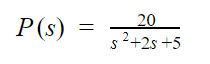

In [ ]:
num = [20]
den = [1, 2, 5]
sys = ctrl.TransferFunction(num, den)
sys

TransferFunction(array([20]), array([1, 2, 5]))

### Resposta ao Degrau Unit√°rio e Desempenho do Sistema

A resposta ao degrau √© obtida a partir da fun√ß√£o plot_step, bem como os par√¢metros de desempenho que s√£o retornados.


{'Erro Estacion√°rio': -2.997694613221578,
 'Overshoot(%)': 20.845412452858305,
 'Pico': 4.8310305439533145,
 'Tempo de Estabiliza√ß√£o': 3.7474747474747474,
 'Tempo de Pico': 1.5555555555555556,
 'Valor de Estabiliza√ß√£o': 3.997694613221578}

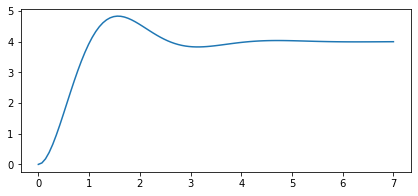

In [ ]:
xs, ys, S = plot_step(sys, 7)
S

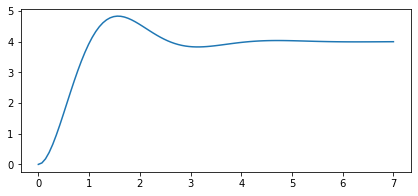

In [ ]:
xs, ys = ctrl.step_response(1*sys, T=7)
 
fig, ax = plt.subplots(figsize=(7,3))
 
ax.plot(xs, ys, linewidth=1.5)

# Lugar das Ra√≠zes

### Lugar das Ra√≠zes e Ganho de Estabilidade M√°xima

O m√©todo lugar das ra√≠zes possibilita ver o gr√°fico das ra√≠zes variando o ganho proporcional direto, e variando o posicionamento dos p√≥los em malha fechada, formando um tra√ßado no plano real x imagin√°rio.



In [ ]:
num = [1]
den = [1, 6, 8, 0]
sys = ctrl.TransferFunction(num, den)
sys

TransferFunction(array([1]), array([1, 6, 8, 0]))

In [ ]:
kvect = np.arange(0,100,.1)

O vetor "kvect" serve para controlar a varia√ß√£o do ganho proporcional direto

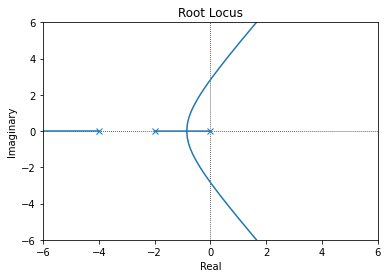

In [ ]:
raizes, ganhos = ctrl.root_locus(sys, kvect=kvect, xlim=[-6,6], ylim=[-6,6], plot=True, print_gain=True, grid=False)

In [ ]:
aux = 480
ganhos[aux], raizes[aux]

(48.0, array([-6.00000000e+00+0.j        ,  3.48679419e-16+2.82842712j,
         3.48679419e-16-2.82842712j]))

Observando os valores do ganho, e os p√≥los em malha fechada associado ao ganho √© possiv√©l encontrar o ganho m√°ximo de estabilidade da planta, pois o ganho m√°ximo de estabilidade significa no gr√°fico o ponto onde o tra√ßado cruza o eixo imagin√°rio, ou seja o valor da parte real do p√≥lo √© proximo a zero


### Projeto baseado no LR

Calcular um ganho Kp para for√ßar que o PSS do sistema seja menor que 20%:

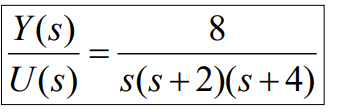


In [ ]:
num = [8]
den = [1, 6, 8, 0]
sys = ctrl.TransferFunction(num, den)
sys

TransferFunction(array([8]), array([1, 6, 8, 0]))

Um PSS < 20% implica em um coeficiente de amortecimento de aproximadamente 0,46. e como o coeficiente de amortecimento est√° diretamente associado aos p√≥los, √© poss√≠vel tra√ßar uma linha com parte real e imagin√°ria, que gera esse coeficiente. Portanto o ponto de intersec√ß√£o entre essa linha e o gr√°fico lugar das ra√≠zes √© o ponto onde ser√° satisfeito a condi√ß√£o de PSS < 20%.

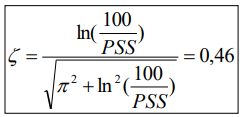

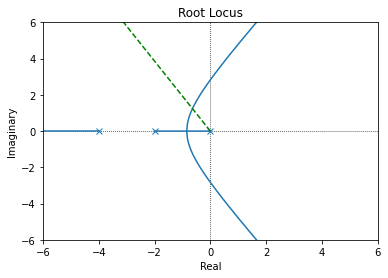

In [ ]:
kvect = np.arange(0,100,.01)
raizes, ganhos = ctrl.root_locus(sys, kvect=kvect, xlim=[-6,6], ylim=[-6,6], plot=True, print_gain=True
                                 , grid=False)
ax = plt.gca()
alfa = np.arccos(0.46)
a = np.tan(alfa)
im = np.arange(0,100,0.01)
re = -im/a
ax.plot(re, im, color='green', linestyle='dashed')

Para encontrar esse ponto de interse√ß√£o ser√° comparado a parte real e imagin√°ria das coordenadas da linha, com as do gr√°fico lugar das ra√≠zes, e quando elas forem pr√≥ximas, ser√£o retornadas o valor das partes reais e imagin√°ria, e a posi√ß√£o de cada vetor 

In [ ]:
for i in range(1000):
  a = 1 
  cc = raizes[i][1]
  ccre = cc.real
  ccim = cc.imag
  for t in range(1000):
    if np.around(re[t], decimals=2)==np.around(ccre, decimals=2) and np.around(im[t], decimals=2)==np.around(ccim, decimals=2):
      print(re[t], ccre)
      print(im[t], ccim)
      print(i, t)
      a = 0
      break
  if a == 0:
    break

-0.6372203478307152 -0.6434082293796458
1.23 1.2332978944053241
114 123


In [ ]:
aux1 = 114
raizes[aux1][1], ganhos[aux1]

((-0.6434082293796458+1.2332978944053241j), 1.1400000000000001)

In [ ]:
aux2 = 123
re[aux2], im[aux2]

Tendo a posi√ß√£o dos vetores, √© poss√≠vel encontrar o ganho associado ao p√≥lo que satisfaz a condi√ß√£o de PSS < 20%, e assim testar a planta com ganho em malha fechada com o comando step, e verificar se a condi√ß√£o foi atendida.

In [ ]:
Gs = 1.15*sys
Ts = ctrl.feedback(Gs)

{'Erro Estacion√°rio': -0.0022030728099475816,
 'Overshoot(%)': 18.475589255754,
 'Pico': 1.1873659960508587,
 'Tempo de Estabiliza√ß√£o': 6.253246753246753,
 'Tempo de Pico': 2.7759740259740258,
 'Valor de Estabiliza√ß√£o': 1.0022030728099476}

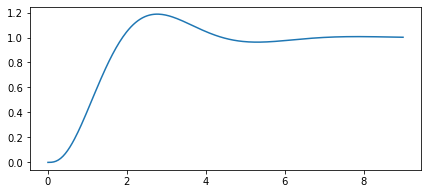

In [ ]:
xs, ys, S = plot_step(Ts, T=9)
S

Como pode ser visto acima, o PSS foi de aproximadamente 18.19%, que atende o requisito de PSS < 20%. 

# Desempenho em frequ√™ncia

### Diagrama de Bode


O diagrama de Bode fornece uma an√°lise no dom√≠nio da frequ√™ncia da planta atrav√©s de 2 gr√°fico, um gr√°fico de magnitude e outro de fase. Para plotar o gr√°fico basta utilizaro o m√©todo bode_plot, da bibliotaca control.

In [ ]:
num = [1]
den = [1, 13, 40, 0]
sys = ctrl.TransferFunction(num, den)
sys

TransferFunction(array([1]), array([ 1, 13, 40,  0]))

Para obter os par√¢metros de Margem de Ganho (Gm, na legenda) e Margem de Fase (Pm, na legenda) basta estabelecer o par√¢metro margins=True, assim como plot=True, para que o gr√°fico seja mostrado, e para que as unidades de magnitude estajam em dB basta estabelecer o par√¢metro dB=True. O par√¢metro omega_limits server para que estabelecer os limites das frequ√™ncias que seram analisadas.

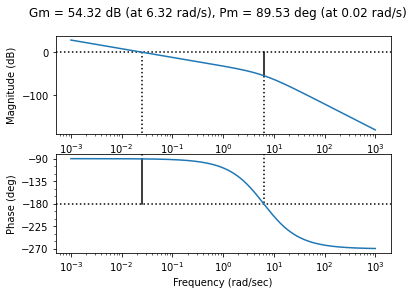

In [ ]:
mag, phase, omega = ctrl.bode_plot(sys, plot=True, margins=True, dB=True, omega_limits=(10e-4, 10e2))

### Diagrama de Nyquist

O diagrama de Nyquist, assim como o de Bode  fornece uma an√°lise no dom√≠nio da frequ√™ncia da planta, por√©m condensado em apenas um gr√°fico.

In [ ]:
num = [16]
den = [1, 6, 8]
sys = ctrl.TransferFunction(num, den)
sys

TransferFunction(array([16]), array([1, 6, 8]))

Para criar o gr√°fico basta executar a fun√ß√£o marginNyquist passando o objeto fun√ß√£o de Transfer√™ncia como argumento. A fun√ß√£o marginNyquist est√° detalhada na se√ß√£o Principais Fun√ß√µes desse notebook. Basicamente o que √© necess√°rio √© ter um circulo de raio unit√°rio que auxilia na extra√ß√£o das informa√ß√µes do gr√°fico, como a Margem de Ganho e de Fase.

/usr/local/lib/python3.7/dist-packages/control/xferfcn.py:318: RuntimeWarning: invalid value encountered in true_divide
  polyval(self.den[i][j], x_arr))


Margem de Fase: 93.49595353578187
Margem de Ganho: nan


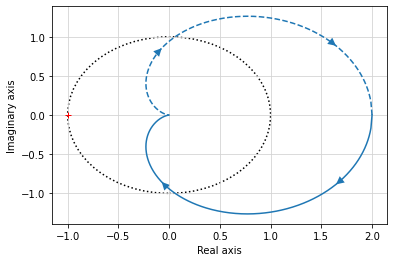

In [ ]:
marginNyquist(sys)

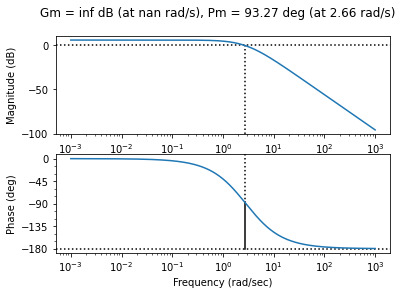

In [ ]:
mag, phase, omega = ctrl.bode_plot(sys, plot=True, margins=True, dB=True, omega_limits=(10e-4, 10e2))

/usr/local/lib/python3.7/dist-packages/control/xferfcn.py:318: RuntimeWarning: invalid value encountered in true_divide
  polyval(self.den[i][j], x_arr))


Margem de Fase: 180.0
Margem de Ganho: nan


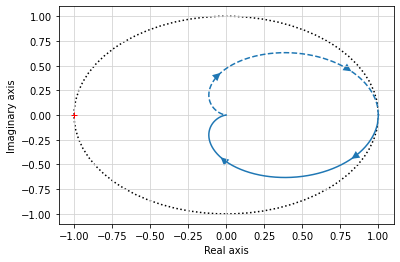

In [ ]:
num = [8]
den = [1, 6, 8]
Ps = ctrl.TransferFunction(num, den)
marginNyquist(Ps)

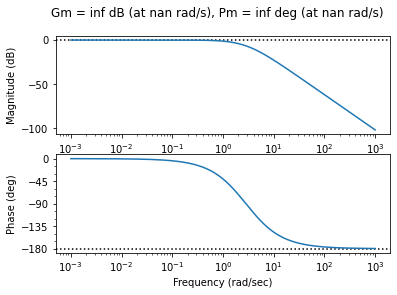

In [ ]:
mag, phase, omega = ctrl.bode_plot(Ps, plot=True, margins=True, dB=True, omega_limits=(10e-4, 10e2))

Margem de Fase: 90.3166524215112
Margem de Ganho: 15.563025007672874


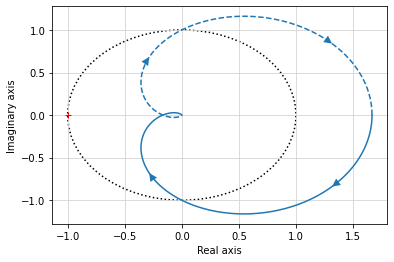

In [ ]:
num = 10
den = [1,6,11,6]
G = ctrl.tf(num, den)
marginNyquist(G)

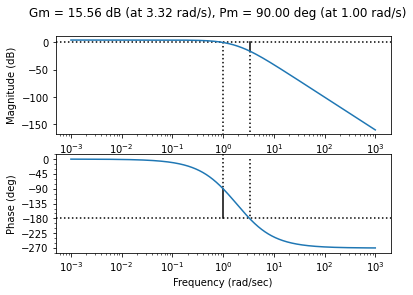

In [ ]:
mag, phase, omega = ctrl.bode_plot(G, plot=True, margins=True, dB=True, omega_limits=(10e-4, 10e2))

In [ ]:
b = 0.169
MG = 20*np.log10(1/b)
MG

# Projeto de Controladores


### Projeto de Controladores - M√©todo Ziegler-Nichols

O m√©todo ZN considera as seguintes f√≥rmulas para os c√°lculos dos ganhos Kp, Kd e Ki.
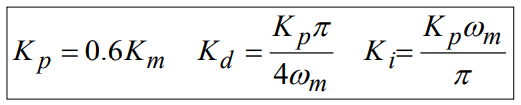


Para exemplificar o procedimento, tem-se o seguinte projeto: Projetar um PID com PSS menor que 20%, e tempo de estabiliza√ß√£o 2% menor que 6 segundos para a planta abaixo:

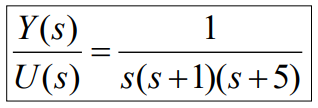

Primeiramente, √© necess√°rio criar o objeto TransferFunction planta P(s)

In [ ]:
num = [1]
den = [1, 6, 5, 0]
Ps = ctrl.TransferFunction(num, den)
Ps

TransferFunction(array([1]), array([1, 6, 5, 0]))

A seguir, para calcular o "Km" e "*w*m" √© preciso achar o ponto de estabilidade m√°ximo, para isso √© utilizado o gr√°fico lugar das ra√≠zes

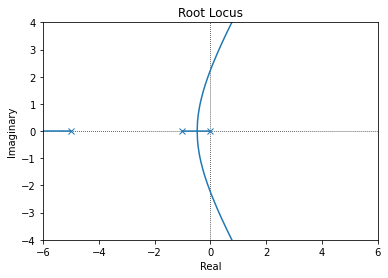

In [ ]:
kvect = np.arange(0, 100, 0.01)
raizes, ganhos = ctrl.root_locus(Ps, kvect=kvect, xlim=[-6,6], ylim= [-4, 4], plot=True, print_gain=True, grid=False)

In [ ]:
#2980
aux = 2980
raizes[aux], ganhos[aux]

(array([-5.99511497e+00+0.j       , -2.44251519e-03+2.2295084j,
        -2.44251519e-03-2.2295084j]), 29.8)

In [ ]:
a=raizes[aux][1]
ar = a.real
ai = a.imag
ar, ai

In [ ]:
Km = ganhos[aux]
wm = ai
Km, wm

Tendo o Km e o *w*m √© poss√≠vel calcular os ganhos do controlador

In [ ]:
kp = 0.6*Km
kd = (kp*np.pi)/4*wm
ki = (kp*wm)/np.pi
kd, kp, ki

Para um controlador PID √© necess√°rio utilizar a fun√ß√£o de transfer√™ncia a seguir:

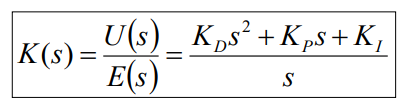

Tendo a fun√ß√£o de transfer√™ncia do controlador, basta fechar a malha e verificar se os requisitos de projeto foram atendidos.

In [ ]:
nk = [kd, kp, ki]
dk = [1,0]
Ks = ctrl.TransferFunction(nk, dk)
Ks

TransferFunction(array([31.30880626, 17.88      , 12.68898124]), array([1, 0]))

In [ ]:
Gs = Ps*Ks
Gs

TransferFunction(array([31.30880626, 17.88      , 12.68898124]), array([1, 6, 5, 0, 0]))

In [ ]:
Ts = ctrl.feedback(Gs)
Ts

TransferFunction(array([31.30880626, 17.88      , 12.68898124]), array([ 1.        ,  6.        , 36.30880626, 17.88      , 12.68898124]))

{'Erro Estacion√°rio': -0.004374104345870045,
 'Overshoot(%)': 14.155000182504686,
 'Pico': 1.1465432606490578,
 'Tempo de Estabiliza√ß√£o': 9.565217391304348,
 'Tempo de Pico': 0.6521739130434783,
 'Valor de Estabiliza√ß√£o': 1.00437410434587}

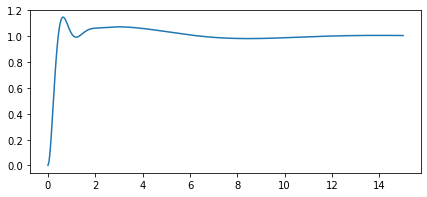

In [ ]:
xs, ys, S = plot_step(Ts, T=15)
S

Caso os requisitos de projeto n√£o sejam atendidos basta ajustar os ganhos Kp, Kd e Ki, e refazer o teste em malha fechada. Lembrando que:


*   Kd influi no amortecimento
*   Ki influi no erro estacion√°rio
*   Kp influi na velocidade de resposta





{'Erro Estacion√°rio': -0.003294757981129326,
 'Overshoot(%)': 14.415601180292786,
 'Pico': 1.1479257289544726,
 'Tempo de Estabiliza√ß√£o': 5.889830508474576,
 'Tempo de Pico': 0.5932203389830508,
 'Valor de Estabiliza√ß√£o': 1.0032947579811293}

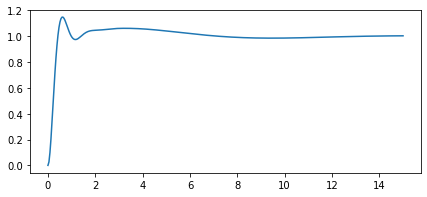

In [ ]:
kd, kp, ki = 33, 18, 11
nk = [kd, kp, ki]
dk = [1,0]
Ks = ctrl.TransferFunction(nk, dk)
Gs = Ps*Ks
Ts = ctrl.feedback(Gs)
xs, ys, S = plot_step(Ts, T=15)
S

### Projeto de Controladores - Resposta em frequ√™ncia

O m√©todo resposta em frequ√™ncia consiste em requisitos de projetos baseados na analise de frequ√™ncia, que s√£o considerados para o c√°lculo dos ganhos Kp e Kd, o ganho Ki geralmente √© calculado a partir da especifica√ß√£o de erro estacion√°rio.

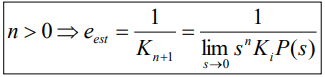

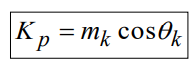

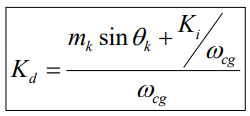

Exemplo: Aplicar a metodologia anal√≠tica para projetar um controlador
PID com margem de fase de 45¬∞
, na frequ√™ncia de cruzamento
de ganho de 5 rad/s e erro estacion√°rio √† par√°bola de 0,1.

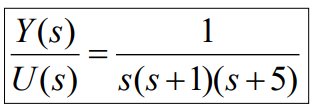

1¬∫ Passo: Criar o objeto fun√ß√£o de transfer√™ncia da planta.

In [ ]:
num = [1]
den = [1, 6, 5, 0]
Ps = ctrl.TransferFunction(num, den)
Ps

TransferFunction(array([1]), array([1, 6, 5, 0]))

2¬∫ Passo: Verificar a frequ√™ncia de cruzamento de ganho (wcg), e a margem de fase (MF) da planta.

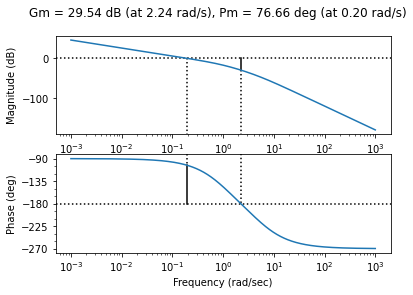

In [ ]:
mag, phase, omega = ctrl.bode_plot(Ps, plot=True, margins=True,  dB=True, omega_limits=(10e-4, 10e2))

3¬∞ Passo: c√°lculo do ganho Ki.

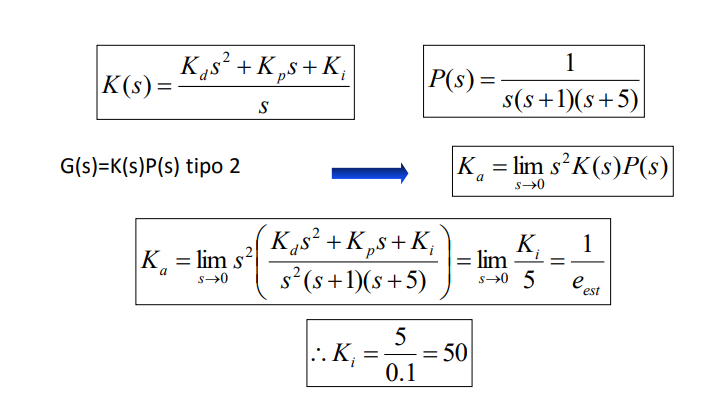


4¬∞ Passo: encontrar o p√≥lo da planta onde wd = wcg, para assim obter o p√≥lo do controlador, e c√°lcular os ganhos Kp e Kd.

In [ ]:
wcg = 5 
MF = (45*np.pi)/180 
ki = 50
mag, phase, omega = ctrl.freqresp(Ps, [wcg])
mp = mag[0]
tetap = phase[0]
tetak = (-np.pi+MF-tetap)
mk = 1/mp
kp = mk*np.cos(tetak)
kd = (((mk*np.sin(tetak))+(ki/wcg))/wcg)
kp=kp
kd=kd
kp, ki, kd

5¬∞ Passo: Criar o objeto fun√ß√£o de transfer√™ncia do controlador, e verificar os requisitos de projeto em malha aberta.

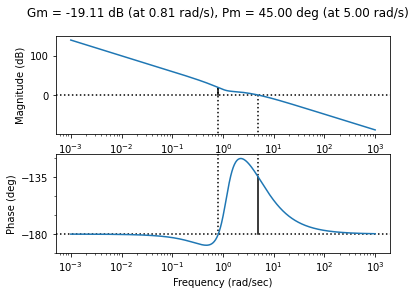

In [ ]:
numk = [kd, kp, ki]
denk = [1, 0]
Ks = ctrl.TransferFunction(numk, denk)
Gs = Ks*Ps
mag, phase, omega = ctrl.bode_plot(Gs, plot=True, margins=True,  dB=True, omega_limits=(10e-4, 10e2))

### Projeto de Controladores - Lugar das Ra√≠zes

O m√©todo Lugar das Ra√≠zes consiste em requisitos de projetos baseados nos par√¢metros de desempenho em malha fechada que est√£o diretamente relacionados ao wn e ao coeficiente de amortecimento.

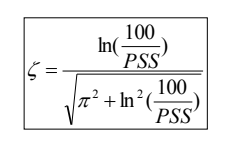

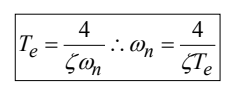

a partir do p√≥lo obtido atrav√©s de Zeta e wn, iremos calcular o p√≥lo em malha fechada (sd) corresponde ao zeta e wn encontrados.

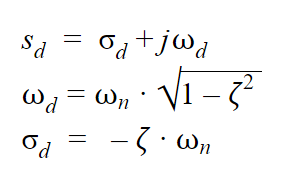

Tendo o p√≥lo (sd) basta avaliar ele na planta pelo comando freqresp, para obter o m√≥dulo (mp) e o √¢ngulo (tetap), e com isso calcular o m√≥dulo e planta do controlador a partir das f√≥rmulas.

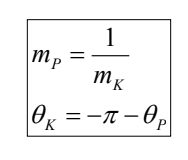

A partir da√≠ basta calcular os fatores a,b,c,d,alpha e beta, para assim calcular Kp e Kd, e o Ki √© baseado no erro estacion√°rio, conforme visto no m√©todo resposta em frequ√™ncia.

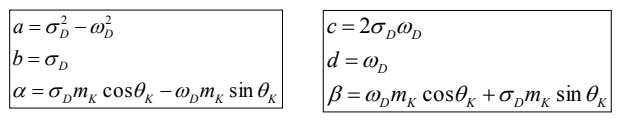

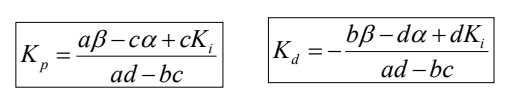

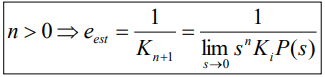

Exemplo: Aplicar a metodologia anal√≠tica para projetar um controlador PID que assegure um PSS de 15%, tempo de estabiliza√ß√£o em 4% de 2s e um erro estacion√°rio ao degrau de 0.

In [ ]:
Ps = ctrl.TransferFunction([200], [1, 5, 0])
Ps

TransferFunction(array([200]), array([1, 5, 0]))

Como o erro estacion√°rio ao degrau deve ser zero iremos utilizar a f√≥mulo abaixo, para calcular o Ki

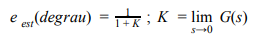

Substituindo a planta em G(s) √© percept√≠vel que o erro estacion√°rio ao degrau sempre ser√° zero, independente do valor de K, portanto adota-se o Ki unit√°rio (ki=1). 
Definido o valor de Ki, podemos come√ßar os c√°lculos de wn e zeta.

In [ ]:
ki = 1
PSS = 15
Te = 2
zeta = np.log(100/PSS)/(np.sqrt(np.pi**2 + np.log(100/PSS)**2))
wn = 4/(zeta*Te)
zeta, wn

A partir dos valores de zeta e wn calcula-se os valores de sigmad e wd, para compor o p√≥lo que ser√° avaliado na planta, a partir do comando freqresp da biblioteca control, e assim retornar os valores mp e tetap.

In [ ]:
sigmad = -zeta*wn
wd = wn*np.sqrt(1- (zeta**2))
sd = complex(sigmad, wd)
mag, phase, omega = ctrl.freqresp(Ps, [sd])
mp = mag[0]
tetap = -phase[0]
mp, tetap, sd

(19.75166372920576, 2.815070192696944, (-2+3.311959895650745j))

Com os valores mp e tetap calcula-se os valores reais e imagin√°rio do p√≥lo do controlador, mk e tetak.

In [ ]:
mk = 1/mp
tetak = -np.pi-tetap
mk, tetak

In [ ]:
a = (sigmad**2) - (wd**2)
b = sigmad
c = 2*sigmad*wd
d = wd
a, b, c, d

In [ ]:
alpha = ((sigmad*np.cos(tetak))-(wd*np.sin(tetak)))*mk
beta = ((wd*np.cos(tetak))+(sigmad*np.sin(tetak)))*mk
alpha, beta

Com os par√¢metros a,b,c,d,alpha e beta √© poss√≠vel calcular os ganhos kd e kp

In [ ]:
kp = ((a*beta)+(c*ki)-(c*alpha))/((a*d)-(c*b))
kd = -((d*ki)-(d*alpha)+(beta*b))/((a*d)-(c*b))
kp, kd, ki

Com os ganhos em m√£os, basta montar a fun√ß√£o de transfer√™ncia do controlador, e fechar a malha com a planta, e testar para verificar se os requisitos de projetos foram atendidos.

{'Erro Estacion√°rio': 0.0002930946131515233,
 'Overshoot(%)': 13.185103282445443,
 'Pico': 1.1315192933838436,
 'Tempo de Estabiliza√ß√£o': 1.742489270386266,
 'Tempo de Pico': 0.5236051502145923,
 'Valor de Estabiliza√ß√£o': 0.9997069053868485}

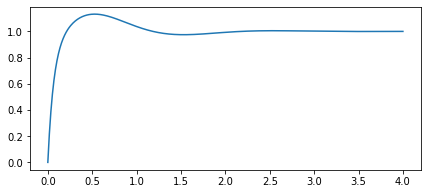

In [ ]:
numk = [kd, kp, 1]
denk = [1, 0]
Ks = ctrl.TransferFunction(numk, denk)
Gs = Ps*Ks
Ts = ctrl.feedback(Gs)
xs, ys, S = plot_step(Ts, T=4)
S

Como pode ser visto, os requisitos de projeto foram atendidos, e ainda √© poss√≠vel verificar o posicionamento dos p√≥los do controlador, pelo comando pzmap da bibiliotca control.

(array([-16.07171679+0.j        ,  -1.6348995 +3.12591185j,
         -1.6348995 -3.12591185j]),
 array([-2.26599147+2.96830086j, -2.26599147-2.96830086j]),
 (-2+3.311959895650745j))

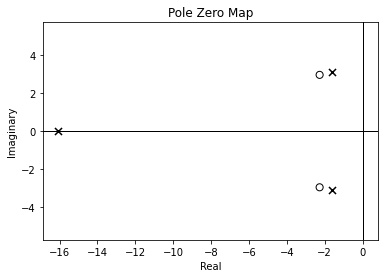

In [ ]:
polos, zeros = ctrl.pzmap(Ts, plot=True, grid=False)
polos, zeros, sd

# Projeto de Compensadores - Avan√ßo/Atraso

√â um controlador mais simples, que consiste de um p√≥lo e um zero. 

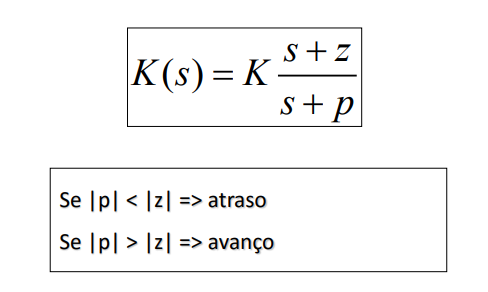

A configura√ß√£o b√°sica do compensador √© a seguinte:

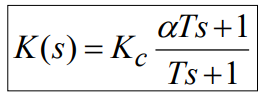

O ganho Kc geralmente √© calculado pela especifica√ß√£o do erro estacion√°rio. E as constantes alpha e T s√£o calculadas de acordo com o m√©todo escolhido.



### Projeto de Compensadores Avan√ßo/Atraso: Resposta em frequ√™ncia

No m√©todo resposta em frequencia o c√°lculo das constantes alpha e T s√£o:

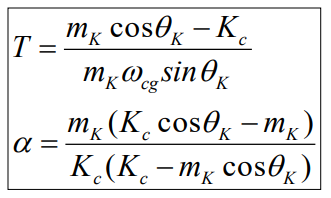

Exemplo: Aplicar a metodologia anal√≠tica para projetar um controlador compensador
com margem de fase de 45¬∞
, na frequ√™ncia de cruzamento de ganho de 5 rad/s
e erro estacion√°rio a rampa de 5.

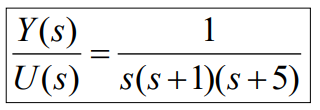

1¬∞ Passo: criar o objeto fun√ß√£o de transfer√™ncia da planta.


In [ ]:
num = [1]
den = [1, 6, 5, 0]
Ps = ctrl.TransferFunction(num, den)
Ps

TransferFunction(array([1]), array([1, 6, 5, 0]))

2¬∞ Passo: Calcular o ganho Kc, e avaliar a planta no frequ√™ncia de cruzamento de ganho, a partir do m√©todo freqresp da biblioteca control, que retorna os p√≥los que geram essa frequ√™ncia.

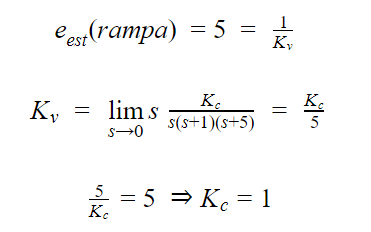


In [ ]:
wcg = 5
MF = 45*np.pi/180
kc = 1
mag, phase, omega = ctrl.freqresp(Ps, [wcg])
mp = mag[0]
tetap = phase[0]
mp, tetap

3¬∞ Passo: Calcular o p√≥lo do compensador, e os par√¢metros T e ùõº para montar o objeto fun√ß√£o de transfer√™ncia do compensador.

In [ ]:
mk = 1/mp
tetak = -np.pi+MF-tetap
T = ((mk*np.cos(tetak)-kc)/(mk*wcg*np.sin(tetak)))
alpha = ((mk*((kc*np.cos(tetak))-mk))/(kc*(kc-(mk*np.cos(tetak)))))

numk = [kc*alpha*T, kc]
denk = [T, 1]

Ks = ctrl.TransferFunction(numk, denk)
Ks

TransferFunction(array([36.72955262,  1.        ]), array([0.03886863, 1.        ]))

4¬∞ Passo: Testar os requisitos de projeto em malha aberta.

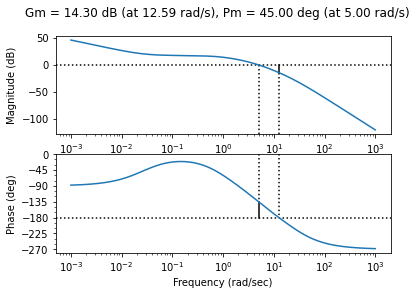

In [ ]:
Gs = Ps*Ks
mag, phase, omega = ctrl.bode_plot(Gs, plot=True, margins=True,  dB=True, omega_limits=(10e-4, 10e2))

### Projeto de Compensadores Avan√ßo/Atraso: Lugar das Ra√≠zes


No m√©todo resposta em frequencia o c√°lculo das constantes alpha e T s√£o:

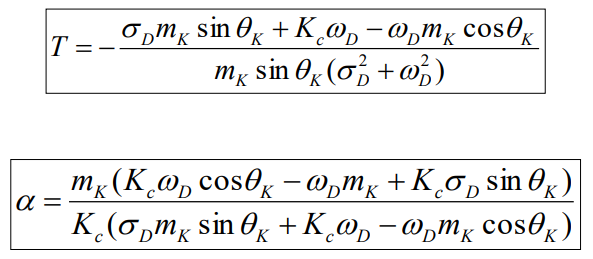

Exemplo: Para a planta abaixo, aplicar a metodologia anal√≠tica para projetar
um controlador que assegure um PSS de 5% e um tempo de
estabiliza√ß√£o de 4 segundos.

In [ ]:
Ps = ctrl.TransferFunction([1], [1, 6, 5, 0])
Ps

TransferFunction(array([1]), array([1, 6, 5, 0]))

Primeiramente √© calculado os valores de zeta e wn.

In [ ]:
PSS = 5
Te = 4
zeta = np.log(100/PSS)/(np.sqrt(np.pi**2 + (np.log(100/PSS)**2)) )
wn = 4/(zeta*Te)
zeta, wn

Com os valores de zeta e wn, √© calculado o valor do p√≥lo (sigmad + jwd) que substituindo na planta obt√©m o zeta e wn correspondentes ao requisito de projeto. E com isso podemos obter o valor de mp e tetap.

In [ ]:
sigmad = -zeta*wn
wd = wn*np.sqrt(1- (zeta**2))
sd = complex(sigmad, wd)
mag, phase, omega = ctrl.freqresp(Ps, [sd])
mp = mag[0]
tetap = -phase[0]
mp, tetap, sd

(0.1691141497876856, 2.035905947303467, (-1+1.0486893910124884j))

Com isso √© calculado o valor do p√≥lo do controlador (mk e tetak).

In [ ]:
mk = 1/mp
tetak = -np.pi-tetap
mk, tetak

Como n√£o h√° especifica√ß√£o de erro estacion√°rio, vamos assumir Kc=1 inicialmente.

In [ ]:
kc=1
T = -((sigmad*mk*np.sin(tetak)) + (kc*wd) - (wd*mk*np.cos(tetak)) )/ (mk*np.sin(tetak)*(sigmad**2 + wd**2))
alpha = (mk/kc)* (( (kc*wd*np.cos(tetak)) - (wd*mk) + (kc*sigmad*np.sin(tetak)) ) / ( (sigmad*mk*np.sin(tetak)) + (kc*wd) - (wd*mk*np.cos(tetak)) ))
numk = [kc*alpha*T, kc]
denk = [T, 1]
Ks = ctrl.TransferFunction(numk, denk)
Ks

TransferFunction(array([3.52986322, 1.        ]), array([0.63237831, 1.        ]))

{'Erro Estacion√°rio': 0.07976455473310173,
 'Overshoot(%)': 0.0,
 'Pico': 0.9202354452668983,
 'Tempo de Estabiliza√ß√£o': 13.577586206896553,
 'Tempo de Pico': 15.0,
 'Valor de Estabiliza√ß√£o': 0.9202354452668983}

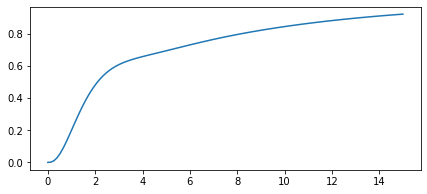

In [ ]:
Gs = Ps*Ks
Ts = ctrl.feedback(Gs)
xs, ys, S = plot_step(Ts, T=15)
S

Como os requisitos de projeto n√£o foram atendidos, √© necess√°rio ajustar o valor de Kc at√© os requisitos serem atendidos.

{'Erro Estacion√°rio': 4.972755163201725e-08,
 'Overshoot(%)': 2.3743050244772173,
 'Pico': 1.0237429993365368,
 'Tempo de Estabiliza√ß√£o': 3.8748019017432647,
 'Tempo de Pico': 3.4231378763866878,
 'Valor de Estabiliza√ß√£o': 0.9999999502724484}

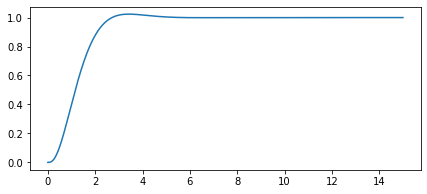

In [ ]:
kc=4.2
T = -((sigmad*mk*np.sin(tetak)) + (kc*wd) - (wd*mk*np.cos(tetak)) )/ (mk*np.sin(tetak)*(sigmad**2 + wd**2))
alpha = (mk/kc)* (( (kc*wd*np.cos(tetak)) - (wd*mk) + (kc*sigmad*np.sin(tetak)) ) / ( (sigmad*mk*np.sin(tetak)) + (kc*wd) - (wd*mk*np.cos(tetak)) ))
numk = [kc*alpha*T, kc]
denk = [T, 1]
Ks = ctrl.TransferFunction(numk, denk)
Gs = Ps*Ks
Ts = ctrl.feedback(Gs)
xs, ys, S = plot_step(Ts, T=15)
S

Como pode ser visto, os valores dos requisitos de projetos foram atendidos, portanto basta verificar o posicionamento dos p√≥los e zeros em malha fechada.

(array([-5.80294017+0.j        , -1.13002272+0.99502417j,
        -1.13002272-0.99502417j, -0.96752044+0.j        ]),
 array([-0.98780881]),
 (-1+1.0486893910124884j))

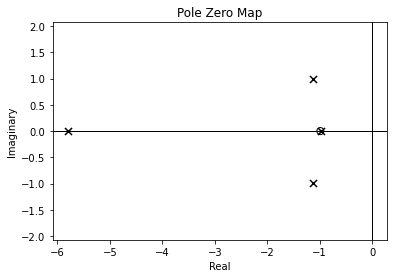

In [ ]:
polos, zeros = ctrl.pzmap(Ts, plot=True, grid=False)
polos, zeros, sd

# Modelo de Espa√ßo de Estados

Para criar um modelo de espa√ßo de estados cont√≠nuo basta passar as Matrices de Estado: A, B, C e D (nessa ordem) para o m√©todo State Space. Como no exemplo de sala do sistema Massa Mola Amortecedor. 

In [ ]:
m = 1. #massa
k = 1. #coef da mola
c = 1. #coef do amortecedor

A = [[0, 1],
     [-k/m, -c/m]]

B = [[0],
     [1/m]]

C = [[1, 0]]

D = [[0]]

SS = ctrl.StateSpace(A,B,C,D)
print(SS.A, '\n') 
print(SS.B, '\n') 
print(SS.C, '\n') 
print(SS.D) 

[[ 0.  1.]
 [-1. -1.]] 

[[0.]
 [1.]] 

[[1. 0.]] 

[[0.]]


Outro modo de criar um modelo de espa√ßo de estados √© a partir de uma fun√ß√£o de transfer√™ncia, pelo m√©todo tf2ss.

In [ ]:
num = [2, 5]
den = [1, 0, 1]
Ps = ctrl.TransferFunction(num, den)
Ps

TransferFunction(array([2, 5]), array([1, 0, 1]))

In [ ]:
SS2 = ctrl.tf2ss(Ps)
print(SS2.A, '\n') 
print(SS2.B, '\n') 
print(SS2.C, '\n') 
print(SS2.D) 

[[-0. -1.]
 [ 1.  0.]] 

[[1.]
 [0.]] 

[[2. 5.]] 

[[0.]]


# Controle por Realimenta√ß√£o de Espa√ßo de Estados

### Realimenta√ß√£o de Estados

A realimenta√ß√£o de Estados permite a realoca√ß√£o dos p√≥los em malha fechada, por√©m n√£o controla a posi√ß√£o dos zeros do numerador, n√£o controla o erro estacion√°rio. Por√©m pode-se corrigir o erro estacion√°rio ajustando um ganho Kp externo.

Exemplo de realimenta√ß√£o de estados:

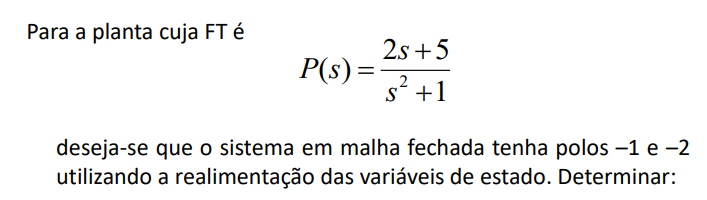

Primeiramente iremos criar o modelo de Espa√ßo de estados a partir da fun√ß√£o de transfer√™ncia

In [ ]:
num = [2, 5]
den = [1, 0, 1]
Ps = ctrl.TransferFunction(num, den)
SS = ctrl.tf2ss(Ps)
SS.A, SS.B, SS.C, SS.D

(array([[-0., -1.],
        [ 1.,  0.]]), array([[1.],
        [0.]]), array([[2., 5.]]), array([[0.]]))

Tendo o sistema, √© obtido a matriz de realimenta√ß√£o "K" a partir do m√©todo acker, e calculado as matrizes At e Bt, a partir de um ganho kp arbitr√°rio. Com as matrizes At e Bt, √© definido o Espa√ßo de Estados com Realimenta√ß√£o "SSR", e plotado um mapa de p√≥los e zeros para verificar se os requisitos foram atendidos. Lembrando que, nesse exemplo tem a particularidade da matriz D ser nula, portanto n√£o h√° altera√ß√£o na matriz Ct.

array([-2., -1.])

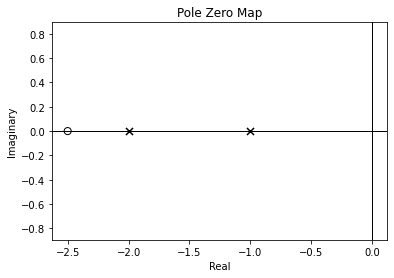

In [ ]:
kp = 1
K = ctrl.acker(SS.A, SS.B, [-1, -2])
At = SS.A - kp*SS.B*K
Bt = kp*SS.B

SSR = ctrl.StateSpace(At, Bt, SS.C, SS.D)
polos, zeros = ctrl.pzmap(SSR, plot=True, grid=False)
polos

### Controle por Espa√ßo de Estados

Dado o Circuito abaixo, onde x1 √© a corrente que atravessa R1, x2 √© a tens√£o em cima de C1, e x3 √© a tens√£o em cima de C2, determina os seguintes itens:


1.   O modelo em Espa√ßo de Estados
2.   O vetor de ganhos K, de forma que o sistema em malha fechada tenha o PSS = 5%; te(2%) = 4s.
3.   O valor de Kp para que o erro estacion√°rio ao degrau seja nulo.
4. A fun√ß√£o de Transfer√™nci I3(s)/V(s)

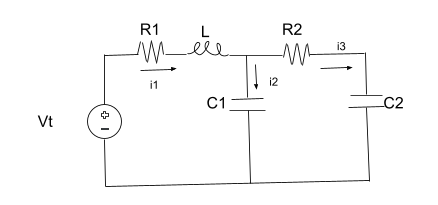

Primeiramente define-se as vari√°veis de Estado. Portanto:


*   i1 = x1
*   Vc1 = x2
*   Vc2 = x3

Depois √© necess√°rio modelar o sistema em fun√ß√£o das vari√°veis de estado e suas derivadas.




Utilizando a lei das malhas e a lei dos n√≥s temos que:  

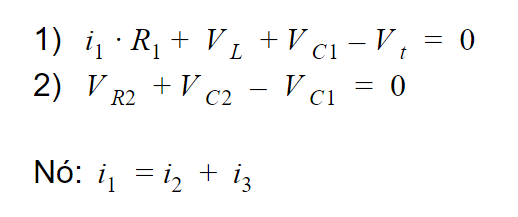

Passando para vari√°veis de Estado:

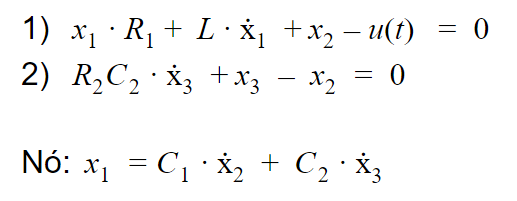

Substituindo x1 em 1) e isolando x1ponto, e isolando x3ponto em 2) temos:

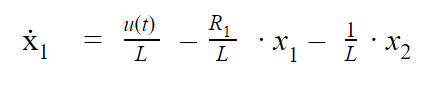


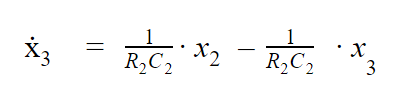

Substituindo X1ponto e x3ponto na equa√ß√£o do N√≥, podemos isolar x2ponto:

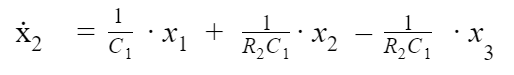

Com as equa√ß√µes em fun√ß√£o das vari√°veis de estado √© poss√≠vel representar o sistema em Espa√ßo de Estados basta atribuir valor √†s constantes de Resist√™ncia, Capacit√¢ncia e Indut√¢ncia.

In [ ]:
r1 = 10e3
r2 = 100e3
L = 1e-3
C1 = 1e-3
C2 = 1.5

In [ ]:
A = [[-r1/L, -1/L, 0],
     [1/C1, -1/(r2*C1), 1/(r2*C1)],
     [0, 1/(r2*C2), -1/(r2*C2)]]

B = [[1/L],
     [0],
     [0]]

C = [0, 0, 1]

D = [0]

SS = ctrl.StateSpace(A, B, C, D)

Com isso conclui-se o item 1)

Para o item 2) primeiramente precisamos saber se o sistema √© control√°vel.

In [ ]:
M = ctrl.ctrb(SS.A, SS.B)
np.linalg.det(M)

Sabendo que o sistema √© control√°vel vamos verificar seu comportamento atrav√©s da sua resposta ao degrau unit√°rio e seu pzmap.

{'Erro Estacion√°rio': 0.0009802140645451818,
 'Overshoot(%)': 0.0,
 'Pico': 0.9990197859354548,
 'Tempo de Estabiliza√ß√£o': 644727.3784314091,
 'Tempo de Pico': 1139785.9011555267,
 'Valor de Estabiliza√ß√£o': 0.9990197859354548}

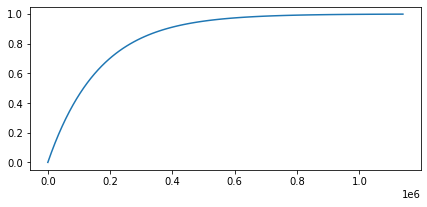

In [ ]:
xs, ys, S = plot_step(SS, T=None)
S

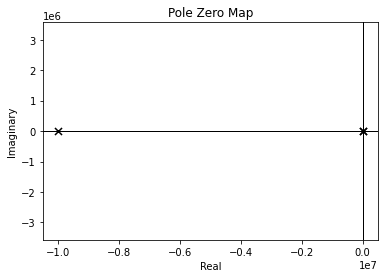

In [ ]:
polos, zeros = ctrl.pzmap(SS)

Com isso, iremos come√ßar o projeto de controle a partir do c√°lculo de zeta e wn.

In [ ]:
PSS = 5
Te = 4
zeta = np.log(100/PSS)/(np.sqrt(np.pi**2 + (np.log(100/PSS)**2)))
wn = 4/(zeta*Te)
zeta, wn

In [ ]:
sigmad = -zeta*wn
wd = wn*np.sqrt(1- (zeta**2))
sd1 = complex(sigmad, wd)
sd2 = complex(sigmad, -wd)
sd1, sd2

((-1+1.0486893910124884j), (-1-1.0486893910124884j))

Com zeta e wn definidos, vamos calcular os p√≥los sigmad +/- j*wd que possibilitam os requisitos de projeto, e inseri-los no sistema a partir do comando Acker, que insere os p√≥los e retorna o vetor de ganhos K. Al√©m dos p√≥los sigmad +/- j*wd iremos inserir um p√≥lo em -2, pois o sistema possui um zero nas proximidades.

In [ ]:
K = acker(SS.A, SS.B,  poles=[sd1, sd2, -2])
K1 = ctrl.place(SS.A, SS.B, p=[sd1, sd2, -2])
K, K1

(array([-9.99999601e+03, -9.99993940e-01,  6.29918772e-01]),
 array([[-9.99999601e+03, -9.99993940e-01,  6.29918772e-01]]))

Com o vetor de ganhos K em m√£o podemos montrar o Espa√ßo de Estados em Malha Fechada, inicialmente com ganho Kp unit√°rio, e assim testar os requisitos de projeto com degrau unit√°rio de amplitude 10.

In [ ]:
Kp = 1
K = K/Kp

In [ ]:
At = SS.A - Kp*SS.B*K
Bt = SS.B*Kp

{'Erro Estacion√°rio': -5.850076807942887,
 'Overshoot(%)': 3.2983293642760305,
 'Pico': 16.372864545559572,
 'Tempo de Estabiliza√ß√£o': 4.6281960343545725,
 'Tempo de Pico': 3.7992654013358433,
 'Valor de Estabiliza√ß√£o': 15.850076807942887}

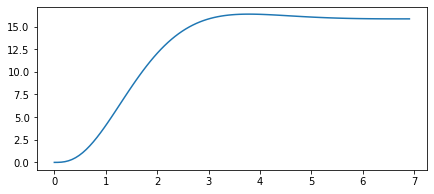

In [ ]:
SS2 = ctrl.StateSpace(At, Bt, C, D)
xs, ys, S = plot_step(SS2, T=None, Amp=10)
S

Apesar do Tempo de Estabiliza√ß√£o estar um pouco acima do desejado, essa diferen√ßa √© toler√°vel para o problema, e podemos modificar a posi√ß√£o do p√≥lo arbitr√°rio. Por√©m, essa diferen√ßa se d√° ao fato dos m√©todos implementados na biblioteca control utilizarem solvers diferentes do MATLAB.

Para o item 3) perceba que o erro estacion√°rio ao degrau esta com um valor diferente de zero, portanto iremos ajustar o ganho Kp para que seja o mais pr√≥ximo de zero poss√≠vel. Primeiramente iremos verificar o valor estacion√°rio do sistema.

In [ ]:
ys[-1]

Para que o erro estacion√°rio tenda a zero, o valor de Kp deve ser a fra√ß√£o entre o valor estacion√°rio desejado, e o valor estacion√°rio atual, ou seja, Kp = 10/15,85.

{'Erro Estacion√°rio': 4.4995118742008344e-12,
 'Overshoot(%)': 3.298329365119087,
 'Pico': 10.32983293650726,
 'Tempo de Estabiliza√ß√£o': 4.628196034605159,
 'Tempo de Pico': 3.799265401541548,
 'Valor de Estabiliza√ß√£o': 9.9999999999955}

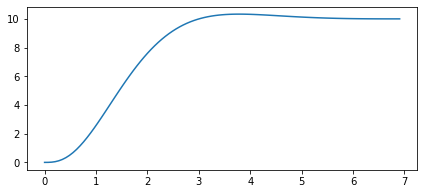

In [ ]:
Kp = 10/ys[-1]
K = K/Kp
At = SS.A - Kp*SS.B*K
Bt = SS.B*Kp
SS2 = ctrl.StateSpace(At, Bt, C, D)
xs, ys, S = plot_step(SS2, T=None, Amp=10)
S

Como pode ser visto o Erros estacion√°rio ao degrau √© praticamente zero, portanto item 3) conclu√≠do.

Por fim, para o item 4) teremos que redefinir as Matrizes C e D do Sistema, de modo que a corrente i3 seja representada pelas vari√°veis de estado. Como a corrente i3 √© a corrente que passa pelo capacitor C2 podemos representa-l√° por:

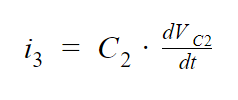

Representando em vari√°veis de Estado:

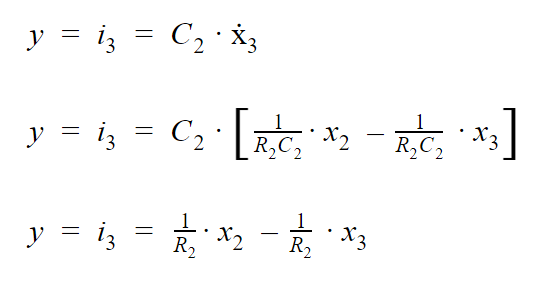

Com isso podemos reescrever as Matrizes C e D, e criar um novo modelo de Espa√ßo de Estados.

In [ ]:
C=[[0, 1/r2, -1/r2]]
D = [[0]]
   
SS3 = ctrl.StateSpace(A,B,C,D)

A partir do comando ss2tf da biblioteca control, podemos chegar na fun√ß√£o de transfer√™ncia da corrente I3.

In [ ]:
tf = ctrl.ss2tf(SS3)
tf

TransferFunction(array([1.86264515e-09, 1.00000000e+01, 4.44089210e-15]), array([1.00000000e+00, 1.00000000e+07, 1.10006667e+06, 6.66666667e+00]))

{'Erro Estacion√°rio': 0.9999999911707084,
 'Overshoot(%)': 102725.9768097955,
 'Pico': 9.078805360899972e-06,
 'Tempo de Estabiliza√ß√£o': 1136821.8650052922,
 'Tempo de Pico': 228.0027807872628,
 'Valor de Estabiliza√ß√£o': 8.829291627050314e-09}

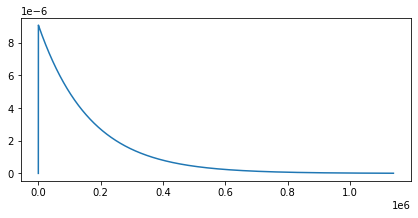

In [ ]:
xs, ys, S = plot_step(SS3, T=None)
S

{'Erro Estacion√°rio': 0.9999999905279766,
 'Overshoot(%)': 95748.63712801288,
 'Pico': 9.078805352677532e-06,
 'Tempo de Estabiliza√ß√£o': 1136593.8622222512,
 'Tempo de Pico': 228.0027807868107,
 'Valor de Estabiliza√ß√£o': 9.472023415995079e-09}

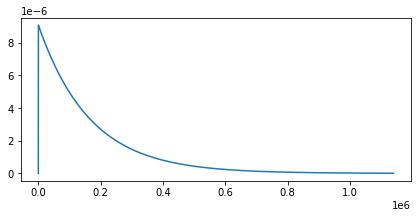

In [ ]:
xs, ys, S = plot_step(tf, T=None)
S

Com isso o item 4) foi conclu√≠do.